Problems: the embeddings I trained is worse than the one from google


Attribution: 
    Some of the code are borrowed from the example code from spacy

In [2]:
import random
import pathlib
import cytoolz
import numpy
from keras.models import Sequential, model_from_json
from keras.layers import LSTM, Dense, Embedding, Bidirectional
from keras.layers import TimeDistributed
from keras.optimizers import Adam
import thinc.extra.datasets
from spacy.compat import pickle
import spacy
import pandas as pd
from sklearn import preprocessing
import keras
from sklearn import model_selection
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### load in SRA data

In [4]:
inS_dir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP/allSRS.pickle'

sra_dump_pickle_dir='/cellar/users/btsui/Data/SRA/DUMP/sra_dump.pickle'

srsS=pd.read_pickle(inS_dir)

technical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)

tmpDf=technical_meta_data_df.drop_duplicates('Sample')

technical_meta_data_df=tmpDf.sample(n=tmpDf.shape[0],random_state=0)

In [10]:
srsS.index.get_level_values(0).nunique()

2921722

In [12]:
len(srsS)

(43907007, 23166485)

### load in spacy models

In [26]:
#!python -m spacy download en_vectors_web_lg

In [38]:
%%time
#nlp=spacy.load('en_vectors_web_lg')
nlp=spacy.load('./wikipedia-pubmed-and-PMC-w2v')

CPU times: user 56.7 s, sys: 7.58 s, total: 1min 4s
Wall time: 1min 4s


### Functions for model compilation and feature extraction
TimeDistributed explained: https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

lr: learning rate, binary_crossentropy


In [39]:
def compile_lstm(embeddings, shape, settings):
    model = Sequential()
    model.add(
        Embedding(
            embeddings.shape[0],
            embeddings.shape[1],
            input_length=shape['max_length'],
            trainable=False,
            weights=[embeddings],
            mask_zero=True
        )
    )
    #the same dense layer is first applied extract the most useful info from embedding layers
    #model.add(TimeDistributed(Dense(shape['nr_hidden'], use_bias=False)))
    model.add(Bidirectional(LSTM(shape['nr_hidden'],
                                 recurrent_dropout=settings['dropout'],
                                 dropout=settings['dropout'])))
    model.add(Dense(shape['nr_class'], activation='sigmoid'))
    model.compile(optimizer=Adam(lr=settings['lr']), loss='binary_crossentropy',
		  metrics=['accuracy'])
    return model

def get_features(docs, max_length):
    docs = list(docs)
    Xs = numpy.zeros((len(docs), max_length), dtype='int32')
    for i, doc in enumerate(docs):
        j = 0
        for token in doc:
            ##rever to word vector
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs

In [41]:
max_length=10

### subset sra data

In [137]:

max_sample_per_study_n=100
subsampledSrs=technical_meta_data_df.groupby('Study').head(n=max_sample_per_study_n)['Sample']
#myAttribs=['collected_by','cell_type','sex','age','growth_protocol','dev_stage','','strain','genotype','disease','cell_line','treatment']
myAttribs=['collected_by','cell_type','sex','age','growth_protocol','dev_stage','strain','genotype','disease','cell_line','treatment']
#myAttribs=['cell type','sex','age','genotype','treatment','SCIENTIFIC_NAME','phenotype']
m=srsS.index.get_level_values(0).isin(subsampledSrs.values)
m1=srsS.index.get_level_values(1).isin(myAttribs)
srsS_subS=srsS[m&m1]

In [119]:
le = preprocessing.LabelEncoder()
le.fit(myAttribs)
myDf=srsS_subS.reset_index()
myDf.columns=['srs','attrib','sentence']

In [120]:
inTrainTestDf=myDf.sample(n=myDf.shape[0]).groupby('attrib').head(n=20000)


In [ ]:
##simpler splitting using train and test
train_df,test_df=model_selection.train_test_split(inTrainTestDf)

### set up LSTM model

In [121]:
nr_hidden=64
max_length=50#, # Shape
dropout=0.5
learn_rate=0.001#, # General NN config
nb_epoch=1#
batch_size=100

In [122]:
nr_classes=len(le.classes_)

In [123]:
lstm_shape={'nr_hidden': 64, 'max_length': max_length, 'nr_class': nr_classes}
lstm_settings={'dropout': 0.5, 'lr': 0.001}

In [124]:
embeddings = nlp.vocab.vectors.data
#embedgigs is vocab.vectors.data
model = compile_lstm(embeddings, lstm_shape, lstm_settings)

### transform list of freetexts to a matrix of word embeddings

In [125]:
train_texts=train_df.sentence.tolist()
dev_texts=test_df.sentence.tolist()

train_labels=keras.utils.to_categorical(
    le.transform(train_df.attrib.values))
dev_labels=keras.utils.to_categorical(le.transform(test_df.attrib.values))

train_docs = list(nlp.pipe(train_texts))
dev_docs = list(nlp.pipe(dev_texts))

train_X = get_features(train_docs, lstm_shape['max_length'])
dev_X = get_features(dev_docs, lstm_shape['max_length'])

#### Model training

In [ ]:
lstm=model.fit(train_X, train_labels, validation_data=(dev_X, dev_labels),
          nb_epoch=nb_epoch, batch_size=batch_size)

In [129]:
val_docs = list(nlp.pipe(dev_texts))
val_X=get_features(val_docs,lstm_shape['max_length'])
predictM=lstm.model.predict_proba(val_X)

In [130]:
tmpDf=pd.DataFrame(data=predictM,columns=le.classes_)

In [131]:
tmpDf.index=pd.MultiIndex.from_arrays([test_df.attrib.values,dev_texts],names=['entity','text'])

In [133]:
probaDf=tmpDf.reset_index()

#### Performance of model in validation cohort

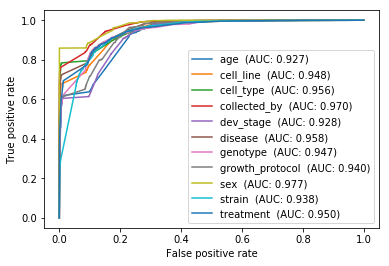

In [134]:
fig,ax=plt.subplots()
for myClass in le.classes_: 
    fpr,tpr,_=metrics.roc_curve((probaDf.entity==myClass),probaDf[myClass])    
    ax.plot(fpr,tpr,label="{myClass}  (AUC: {AUC})".format(myClass=myClass,AUC=str(metrics.auc(fpr,tpr))[:5]))
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.legend()

### for a sentence split

In [89]:
import nltk
from nltk.util import ngrams


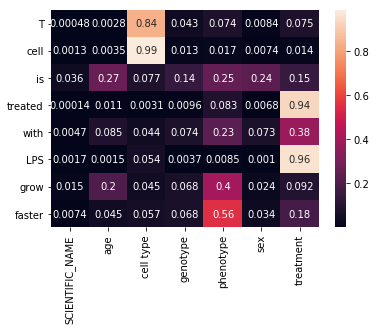

In [93]:
sent="T cell is treated with LPS grow faster"
s=sent.split(' ')
#def find_ngrams(input_list, n):
#    return zip(*[input_list[i:] for i in range(n)])
val_docs = list(nlp.pipe(s))
val_X=get_features(val_docs,lstm_shape['max_length'])

tmpDf=pd.DataFrame(data=lstm.model.predict_proba(val_X),columns=le.classes_,index=s)
sns.heatmap(tmpDf,annot=True)

['T cell', 'cell is', 'is treated', 'treated with', 'with LPS', 'LPS grow', 'grow faster']


Text(0.5,1,'2 grams')

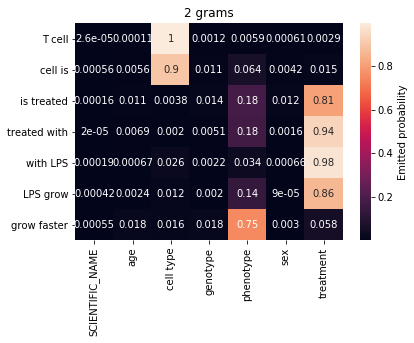

In [95]:
n_gram=2
grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
print (grams)
val_docs = list(nlp.pipe(grams))
val_X=get_features(val_docs,lstm_shape['max_length'])

tmpDf=pd.DataFrame(data=lstm.model.predict_proba(val_X),columns=le.classes_,index=grams)
ax=sns.heatmap(tmpDf,cbar_kws={'label': 'Emitted probability'},annot=True)
ax.set_ylabel('')
ax.set_title('{} grams'.format(n_gram))

In [90]:
val_X=get_features(val_docs,lstm_shape['max_length'])

In [ ]:
!echo $PWD/Data/DEEP_NLP/NLP_spacy/keras_on_sra_data_v2.ipynb

In [ ]:
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(lstm.model).create(prog='dot', format='svg'))

In [ ]:
#!pip install pydot

In [ ]:
#from keras.utils import plot_model
#plot_model(model, to_file='model.png')


In [101]:
import gensim

In [102]:
gensim.__version__

'3.4.0'

In [2]:
#!cat /proc/cpuinfo
#https://code.google.com/archive/p/word2vec/

Process is interrupted.


In [37]:
#!python -m spacy init-model en ./wikipedia-pubmed-and-PMC-w2v --vectors-loc ./Data/wikipedia-pubmed-and-PMC-w2v.txt


Reading vectors from Data/wikipedia-pubmed-and-PMC-w2v.txt
5443656it [05:24, 16789.92it/s]
Creating model...
0it [00:00, ?it/s]

    Sucessfully compiled vocab
    5443363 entries, 5443656 vectors



In [36]:
!ls ./Data/

GoogleNews-vectors-negative300.bin.gz
NCIT_table.pickle
PMC-ids.csv.gz
pmc_word2_vec.gensim
pmc_word2_vec.gensim.trainables.syn1neg.npy
pmc_word2_vec.gensim.wv.vectors.npy
pmc_word2_vec.pandas.threshold.10.pickle
pmc_word2_vec.pandas.threshold.100.pickle
pmc_word2_vec.pandas.threshold.200.pickle
pmc_word2_vec.txt
spacy_bio_nlp
wikipedia-pubmed-and-PMC-w2v.bin
wikipedia-pubmed-and-PMC-w2v.txt


In [ ]:
!wget http://evexdb.org/pmresources/vec-space-models/wikipedia-pubmed-and-PMC-w2v.bin